In [24]:
# load dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score

# Pre-Processing Steps for Model Definitions

In [43]:
# Load data
df = pd.read_csv('../data/clean/alzheimers.csv')
df.head()

,ADL,MMSE,FunctionalAssessment,MemoryComplaints,BehavioralProblems,Diagnosis
0,-1.104434,0.779037,0.497506,0,0,0
1,-0.810601,0.680297,0.704907,0,0,0
2,0.724491,-0.859222,0.281813,0,0,0
3,0.508044,-0.088723,1.343346,0,1,0
4,-1.684679,-0.143712,0.333665,0,0,0


In [ ]:
# Define X and y for our models
X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1: MLPClassifier

In [ ]:
# Initialize MLPClassifier model
model = MLPClassifier(hidden_layer_sizes=(64, 64), activation='relu', solver='adam', random_state=42)

In [ ]:
# Fit our first model
model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:785: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,"hidden_layer_sizes hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)The ith element represents the number of neurons in the ithhidden layer.","(64, ...)"
,"activation activation: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'Activation function for the hidden layer.- 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x- 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).- 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).- 'relu', the rectified linear unit function, returns f(x) = max(0, x)",'relu'
,"solver solver: {'lbfgs', 'sgd', 'adam'}, default='adam'The solver for weight optimization.- 'lbfgs' is an optimizer in the family of quasi-Newton methods.- 'sgd' refers to stochastic gradient descent.- 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaFor a comparison between Adam optimizer and SGD, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_training_curves.py`.Note: The default solver 'adam' works pretty well on relativelylarge datasets (with thousands of training samples or more) in terms ofboth training time and validation score.For small datasets, however, 'lbfgs' can converge faster and performbetter.",'adam'
,"alpha alpha: float, default=0.0001Strength of the L2 regularization term. The L2 regularization termis divided by the sample size when added to the loss.For an example usage and visualization of varying regularization, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_alpha.py`.",0.0001
,"batch_size batch_size: int, default='auto'Size of minibatches for stochastic optimizers.If the solver is 'lbfgs', the classifier will not use minibatch.When set to ""auto"", `batch_size=min(200, n_samples)`.",'auto'
,"learning_rate learning_rate: {'constant', 'invscaling', 'adaptive'}, default='constant'Learning rate schedule for weight updates.- 'constant' is a constant learning rate given by 'learning_rate_init'.- 'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of 'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)- 'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.Only used when ``solver='sgd'``.",'constant'
,"learning_rate_init learning_rate_init: float, default=0.001The initial learning rate used. It controls the step-sizein updating the weights. Only used when solver='sgd' or 'adam'.",0.001
,"power_t power_t: float, default=0.5The exponent for inverse scaling learning rate.It is used in updating effective learning rate when the learning_rateis set to 'invscaling'. Only used when solver='sgd'.",0.5
,"max_iter max_iter: int, default=200Maximum number of iterations. The solver iterates until convergence(determined by 'tol') or this number of iterations. For stochasticsolvers ('sgd', 'adam'), note that this determines the number of epochs(how many times each data point will be used), not the number ofgradient steps.",200
,"shuffle shuffle: bool, default=TrueWhether to shuffle samples in each iteration. Only used whensolver='sgd' or 'adam'.",True
,"random_state random_state: int, RandomState instance, default=NoneDetermines random number generation for weights and biasinitialization, train-test split if early stopping is used, and batchsampling when solver='sgd' or 'adam'.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42


In [ ]:
# Define predictions for MLPClassifier
predictions = model.predict(X_test)

# Print out the standard metrics of evaluating accuracy
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       277
           1       0.96      0.88      0.91       153

    accuracy                           0.94       430
   macro avg       0.95      0.93      0.94       430
weighted avg       0.94      0.94      0.94       430

0.9418604651162791


In [ ]:
# Create a sample dataset from our training data
# This step reduces computation burden while maximizing results due to CLT
# It is not fully necessary, but is good practice when dealing with large datasets
X_background = X_train.sample(100, random_state=42)

# Define the explainer using "predict_proba" and sample dataset
explainer = shap.Explainer(
    model.predict_proba,
    X_background
)

# Define our SHAP values
shap_values = explainer(X_test)

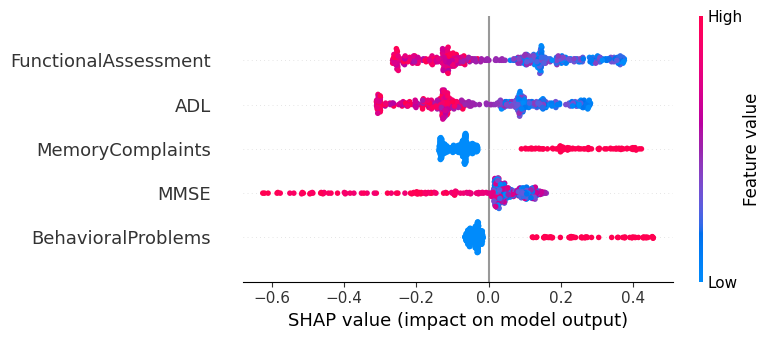

In [ ]:
# Print out the SHAP summary plot for our MLPClassifier model
shap.summary_plot(
    shap_values.values[:, :, 1],
    X_test,
    feature_names=X_test.columns
)

### Takeaways
For our MLPClassifier model, we can see that high values in FunctionalAssessment, ADL, and MMSE *generally* correspond 
to a reduction in"risk," which represents a diagnosis of Alzheimer's disease in our case. Conversely, if a patient has 
a lower valuein one of these metrics, these values impact the model into being more likely to produce a positive diagnosis 
(one that identifies Alzheimer's, that is)

On the other hand, high vales in our binary columns (MemoryComplaints, BehavioralProblems) correspond to a greater
chance of a positive diagnosis, while a lack of these symptoms (a 0 in the binary column) corresponds to a lower
chance of a patient being diagnosed with Alzheimer's.

These are invaluable insights into how our model has identified key aspects of a patient's status and come up
with a way of quantifying how a certain value in those categories should influence one's expectation regarding
an Alzheimer's diagnosis.

## Waterfall Plots for Specific Patients (Diagnosed and Not Diagnosed)

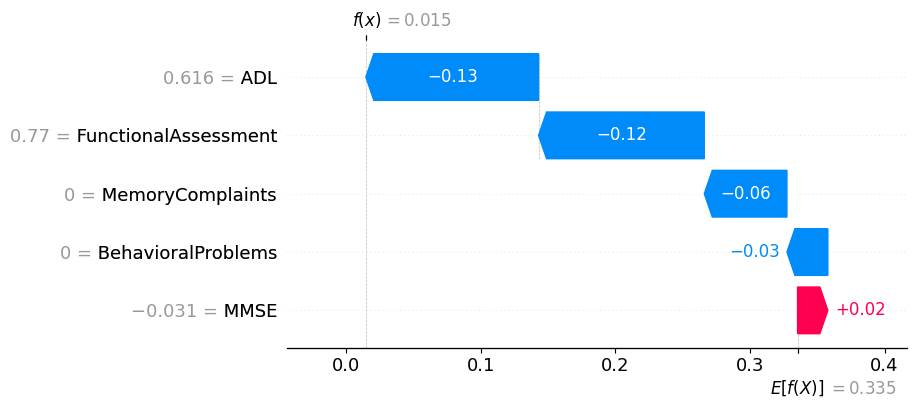

In [68]:
# Define our data to be printed into waterfall for the first row of our test data
exp = shap.Explanation(
    values=shap_values.values[0, :, 1],  
    base_values=shap_values.base_values[0, 1], 
    data=X_test.iloc[0],
    feature_names=X_test.columns
)

# Print waterfall plot for how different attributes of the first patient
# contributed to the prediction of Alzheimer's disease (their diagnosis)
# Negative values indicate a reduction in certainty of Alzheimer's disease
# Positive values indicate the inverse
shap.plots.waterfall(exp, max_display=5)

In [ ]:
# Check the actual and predicted diagnosis for the first patient in our test set
print(f"First patient's predicted diagnosis: {predictions[0]}")
print(f"First patient's actual diagnosis: {y_test.iloc[0]}")

First patient's predicted diagnosis: 0
First patient's actual diagnosis: 0


In [76]:
# From this, we can see that the model predicted the tenth person to have Alzheimer's, which is correct.
print(f"Tenth patient's predicted diagnosis: {predictions[9]}")
print(f"Tenth patient's actual diagnosis: {y_test.iloc[9]}")

Tenth patient's predicted diagnosis: 1
Tenth patient's actual diagnosis: 1


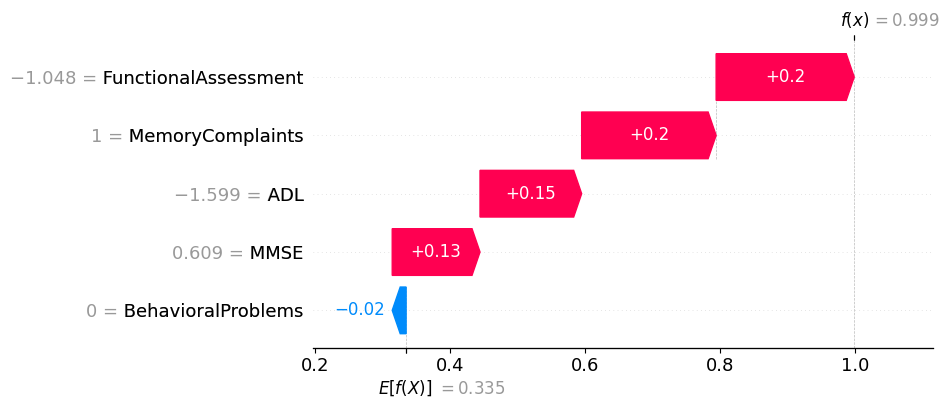

In [69]:
# Do the same as above for a patient with Alzheimer's disease
exp = shap.Explanation(
    values=shap_values.values[9, :, 1],  
    base_values=shap_values.base_values[9, 1], 
    data=X_test.iloc[9],
    feature_names=X_test.columns
)

shap.plots.waterfall(exp, max_display=5)

# Model 2: Logistic Regression

In [ ]:
# Initialize and fit Logistic Regression model
model2 = LogisticRegression()
model2.fit(X_train, y_train)

# Get predictions from LR model
y_pred2 = model2.predict(X_test)

In [ ]:
# Define another sample dataset from our training data
X_background2 = X_train.sample(100, random_state=42)

In [ ]:
# Define the explainer using "predict_proba" and sample dataset
# Then, calculate the SHAP values for the LR model
explainer2 = shap.Explainer(model2.predict_proba, X_background2)
shap_value2 = explainer2(X_test)

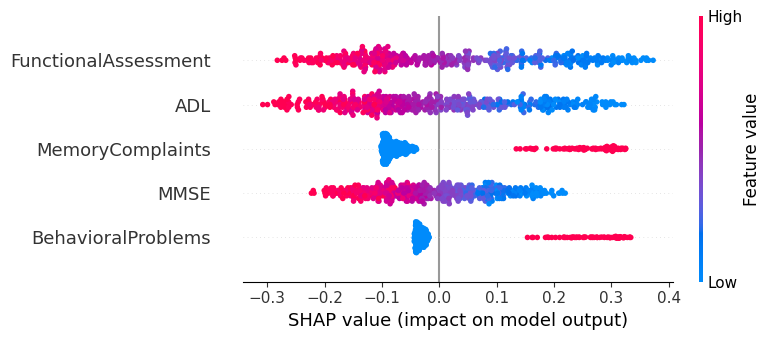

In [ ]:
# Define and print out the summary plot
shap.summary_plot(
    shap_value2.values[:, :, 1],
    X_test,
    feature_names=X_test.columns
)

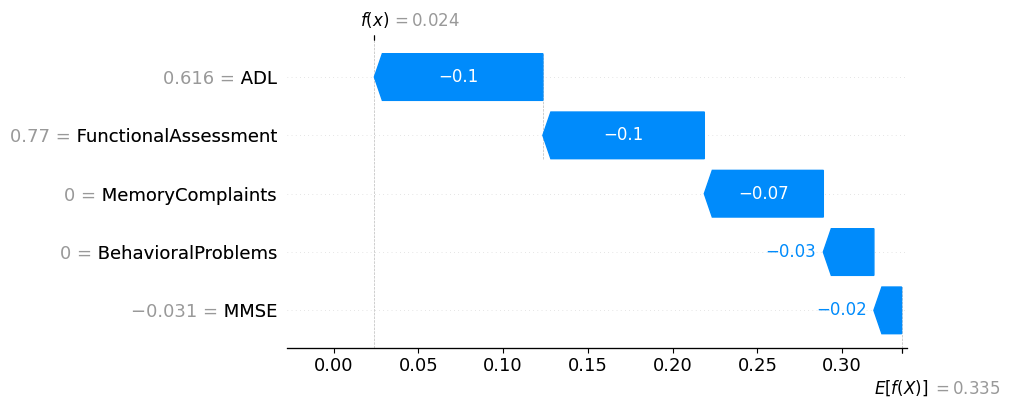

In [55]:
exp = shap.Explanation(
    values=shap_value2.values[0, :, 1],  
    base_values=shap_value2.base_values[0, 1], 
    data=X_test.iloc[0],
    feature_names=X_test.columns
)

shap.plots.waterfall(exp, max_display=10)

In [78]:
# Check the actual and predicted diagnosis for the first patient in our test set
print(f"First patient's predicted diagnosis: {y_pred2[0]}")
print(f"First patient's actual diagnosis: {y_test.iloc[0]}")

First patient's predicted diagnosis: 0
First patient's actual diagnosis: 0


In [81]:
# Check the actual and predicted diagnosis for the tenth patient in our test set
print(f"Tenth patient's predicted diagnosis: {y_pred2[9]}")
print(f"Tenth patient's actual diagnosis: {y_test.iloc[9]}")

Tenth patient's predicted diagnosis: 1
Tenth patient's actual diagnosis: 1


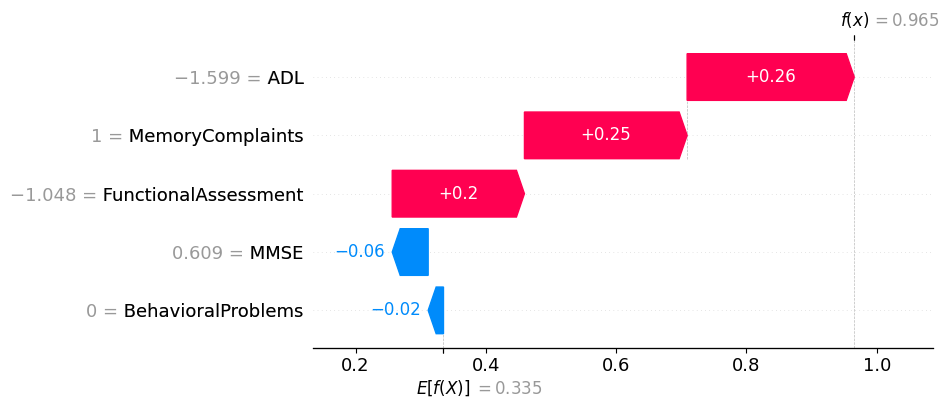

In [82]:
# Do the same as above for a patient with Alzheimer's disease
exp = shap.Explanation(
    values=shap_value2.values[9, :, 1],  
    base_values=shap_value2.base_values[9, 1], 
    data=X_test.iloc[9],
    feature_names=X_test.columns
)

shap.plots.waterfall(exp, max_display=5)

# Model 3: RandomForestClassifier

ExactExplainer explainer: 431it [00:10,  1.02s/it]                         


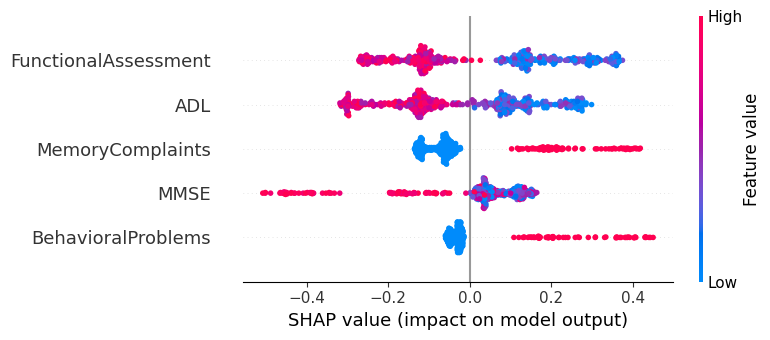

In [ ]:
# Define and fit our RandomForest model
model3 = RandomForestClassifier()
model3.fit(X_train, y_train)

# Define our predictions and a third sample dataset
y_pred3 = model3.predict(X_test)
X_background3 = X_train.sample(100, random_state=42)

# Define the explainer and calculate SHAP values
explainer3 = shap.Explainer(model3.predict_proba, X_background3)
shap_value3 = explainer3(X_test)

# Print out the summary plot
shap.summary_plot(
    shap_value3.values[:, :, 1],
    X_test,
    feature_names=X_test.columns
)

In [83]:
# Check the actual and predicted diagnosis for the first patient in our test set
print(f"First patient's predicted diagnosis: {y_pred3[0]}")
print(f"First patient's actual diagnosis: {y_test.iloc[0]}")

First patient's predicted diagnosis: 0
First patient's actual diagnosis: 0


In [84]:
# Check the actual and predicted diagnosis for the tenth patient in our test set
print(f"Tenth patient's predicted diagnosis: {y_pred3[9]}")
print(f"Tenth patient's actual diagnosis: {y_test.iloc[9]}")

Tenth patient's predicted diagnosis: 1
Tenth patient's actual diagnosis: 1


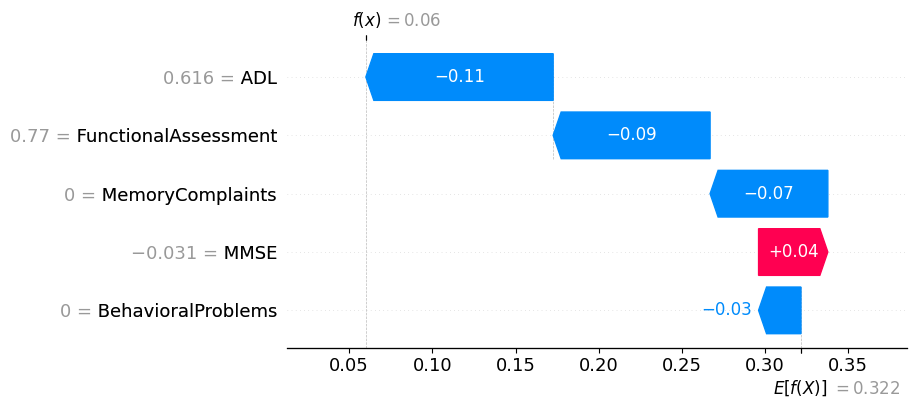

In [86]:
# Do the same as above for a patient with Alzheimer's disease
exp = shap.Explanation(
    values=shap_value3.values[0, :, 1],  
    base_values=shap_value3.base_values[0, 1], 
    data=X_test.iloc[0],
    feature_names=X_test.columns
)

shap.plots.waterfall(exp, max_display=5)

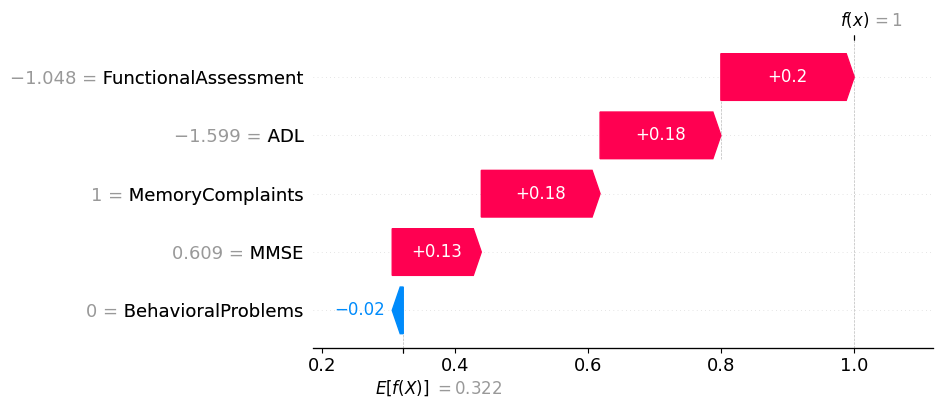

In [87]:
# Do the same as above for a patient with Alzheimer's disease
exp = shap.Explanation(
    values=shap_value3.values[9, :, 1],  
    base_values=shap_value3.base_values[9, 1], 
    data=X_test.iloc[9],
    feature_names=X_test.columns
)

shap.plots.waterfall(exp, max_display=5)

# Overall Thoughts

I think that looking at these different models and how they made their predictions on the same people based on the
same factors can be incredibly interesting. I think it could be eye-opening to find a situation where the models
made different predictions and see how that could happen, despite the fact that a different model given the same
exact information (besides having its SHAP explainer trained on different background data, which we already
established should be a rather negligible difference) can come to a correct conclusion.